#### 13. This question should be answered using the Weekly data set, which is part of the `ISLP` package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains $1089$ weekly returns for $21$ years, from the beginning of $1990$ to the end of $2010$.
1. Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?
2. Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?
3. Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.
4. Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).
5. Repeat (4) using LDA.
6. Repeat (4) using QDA.
7. Repeat (4) using KNN with $K = 1$.
8. Which of these methods appears to provide the best results on this data?
9. Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [1]:
import numpy as np
import pandas as pd
from pandera.typing import Series

import matplotlib.pyplot as plt

import ISLP
import ISLP.models

import statsmodels.api as sm

In [2]:
Weekly: pd.DataFrame = ISLP.load_data("Weekly")
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [3]:
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [4]:
print(len(Weekly), len(Weekly[Weekly.Direction == "Up"]), len(Weekly[Weekly.Direction == "Down"]))

1089 605 484


In [5]:
Weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Text(0, 0.5, 'Volume')

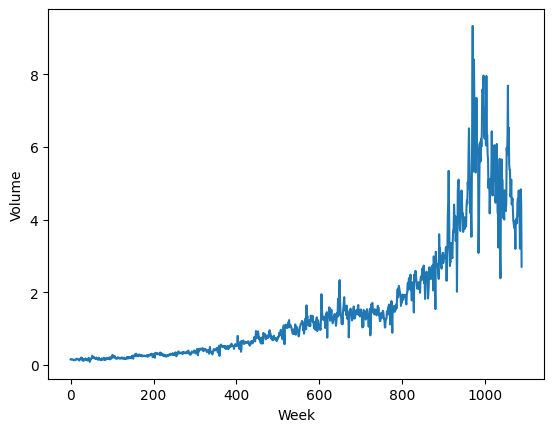

In [6]:
plt.plot(range(len(Weekly)), Weekly.Volume)
plt.xlabel("Week")
plt.ylabel("Volume")

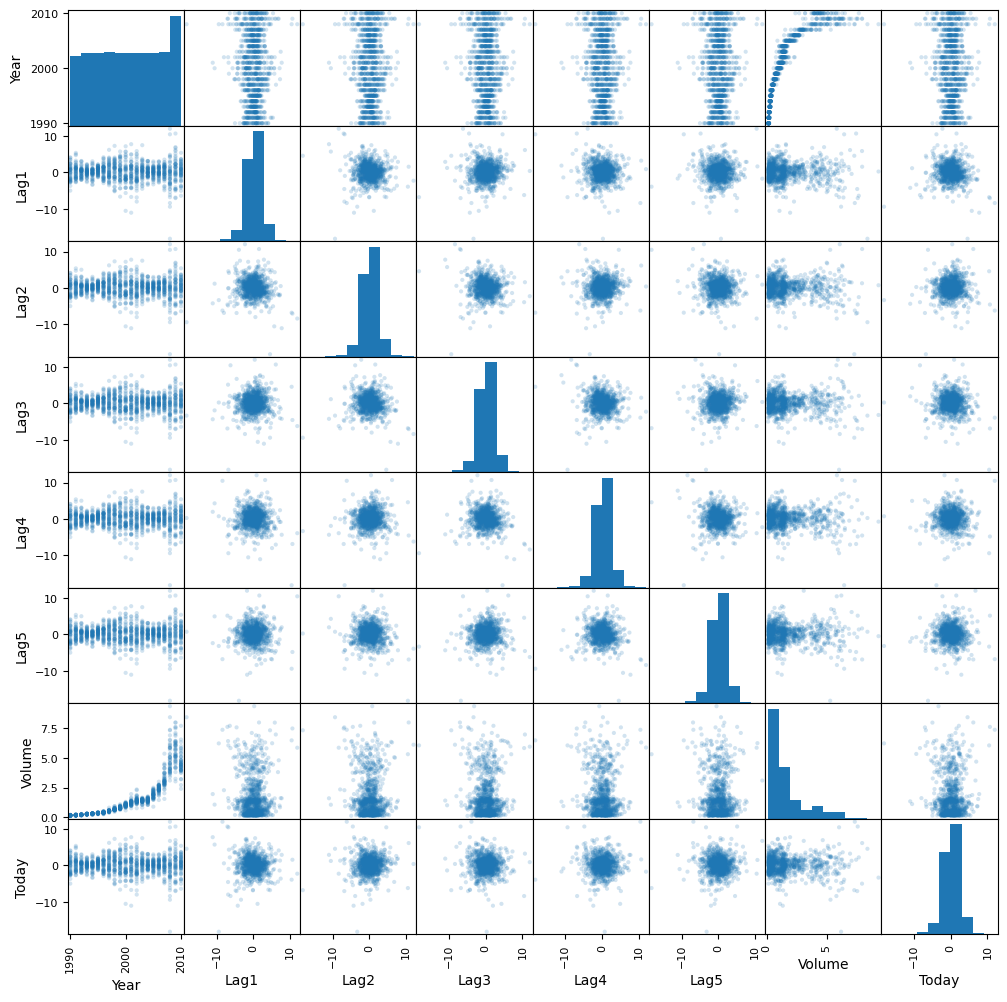

In [7]:
pd.plotting.scatter_matrix(Weekly, alpha=0.2, figsize=(12, 12), diagonal="hist");

## 2

In [8]:
allvars: list[str] = [f"Lag{i + 1}" for i in range(5)] + ["Volume"]
design = ISLP.models.ModelSpec(allvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == "Up"
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
_summary: pd.DataFrame = ISLP.models.summarize(results)

In [9]:
stat_sig_threshold = 0.05
stat_sig_params: list[str] = [
    name for name, _ in _summary[_summary["P>|z|"] < stat_sig_threshold].iterrows()
    if name != "intercept"
]
stat_sig_params

['Lag2']

## 3

In [10]:
labels = np.where(results.predict() > 0.5, "Up", "Down")
ct = ISLP.confusion_table(labels, Weekly.Direction)
ct

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


We are significantly overpredicting up.

In [11]:
pct_correct_total = np.mean(labels == Weekly.Direction)
print(f"Our model predicts the correct movement {pct_correct_total*100:.2f}% of the time.")

for dir_ in ["Up", "Down"]:
    pct = ct.loc[dir_][dir_]/(ct.loc[dir_].sum())
    print(f"Our model is correct when it predicts an '{dir_}' movement {pct*100:.2f}% of the time.")

Our model predicts the correct movement 56.11% of the time.
Our model is correct when it predicts an 'Up' movement 56.43% of the time.
Our model is correct when it predicts an 'Down' movement 52.94% of the time.


## 4

In [12]:
Weekly: pd.DataFrame = ISLP.load_data("Weekly")
train: pd.DataFrame = Weekly[Weekly.Year <= 2008].copy()
test: pd.DataFrame = Weekly[Weekly.Year > 2008].copy()

In [13]:
from statsmodels.genmod.generalized_linear_model import GLMResultsWrapper

allvars2: list[str] = ["Lag2"]
design = ISLP.models.ModelSpec(allvars2)
X2: np.ndarray = design.fit_transform(train)
y2: Series[bool] = train.Direction == "Up"
glm2 = sm.GLM(y2, X2, family=sm.families.Binomial())
results2: GLMResultsWrapper = glm2.fit()
_summary2: pd.DataFrame = ISLP.models.summarize(results)

In [14]:
probs = results2.predict(exog=design.fit_transform(test))
labels2 = np.where(probs > 0.5, "Up", "Down")
ct = ISLP.confusion_table(labels2, test.Direction)
ct

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [15]:
print(f"Using only 'Lag2' we get correct predictions {np.mean(labels2 == test.Direction)*100:.2f}% of the time.")

Using only 'Lag2' we get correct predictions 62.50% of the time.


## 5

In [16]:
design = ISLP.models.ModelSpec(allvars2)
X3 = design.fit_transform(train)

In [17]:
X3

,intercept,Lag2
0,1.0,1.572
1,1.0,0.816
2,1.0,-0.270
3,1.0,-2.576
4,1.0,3.514
...,...,...
980,1.0,-8.389
981,1.0,12.026
982,1.0,-2.251
983,1.0,0.418


In [18]:
import sklearn.discriminant_analysis

lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
X = train[["Lag2"]].copy()
X["intercept"] = 1.0
X = X[["intercept", "Lag2"]]
lda.fit(X = X, y = train.Direction)

LinearDiscriminantAnalysis(store_covariance=True)

In [19]:
X_test = test[["Lag2"]].copy()
X_test["intercept"] = 1.0
X_test = X_test[["intercept", "Lag2"]]

In [20]:
print(f"We predict {np.mean(lda.predict(X_test) == test.Direction)*100:.2f}% correctly.")

We predict 62.50% correctly.


In [21]:
ct = ISLP.confusion_table(lda.predict(X_test), test.Direction)
ct

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [22]:
ct.loc["Down"]["Down"]

9

In [23]:
len([1 for x in lda.predict_proba(X_test) if x[1] <= 0.5]) / len(lda.predict_proba(X_test))

0.1346153846153846

## 6

In [24]:
Weekly: pd.DataFrame = ISLP.load_data("Weekly")
train = Weekly[Weekly.Year <= 2008].copy()
test = Weekly[Weekly.Year > 2008].copy()

In [25]:
X_train = train[["Lag2"]].copy()
X_train["intercept"] = 1.0
X_train = X_train[["intercept", "Lag2"]]

In [26]:
import sklearn.discriminant_analysis

qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train[["Lag2"]], train.Direction)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [27]:
qda.predict(X_test[["Lag2"]])

array(['Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up'], dtype=object)

## 7

## 8

## 9